In [1]:
%pylab inline
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from mpl_toolkits.basemap import Basemap
import folium
from folium.plugins import HeatMap
import statsmodels.api as sm
import warnings
from itertools import product
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


# Прогнозирование ряда со сложной сезонностью

## 1. Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! 

Создайте регрессионные признаки для учёта сезонностей и трендов (выполнено в следующем пункте).

Загрузим данные за период с 1 января по 31 мая 2016 года.

In [2]:
data_all = pd.read_csv("C:\\Users\\User\\Documents\\taxi\\taxi_train_01_05.csv", sep=";", index_col=False)

In [3]:
data_all

,dt,region,count
0,2016-01-01 00:00:00,1,0.0
1,2016-01-01 00:00:00,2,0.0
2,2016-01-01 00:00:00,3,0.0
3,2016-01-01 00:00:00,4,0.0
4,2016-01-01 00:00:00,5,0.0
5,2016-01-01 00:00:00,6,0.0
6,2016-01-01 00:00:00,7,0.0
7,2016-01-01 00:00:00,8,0.0
8,2016-01-01 00:00:00,9,0.0
9,2016-01-01 00:00:00,10,0.0


Будем использовать зону, в которой находится Empire State Building, эта зона точно содержит данные в соответствии с графиками недели 2. Произведем фильтрацию данных.

In [4]:
esb_zone = 1231

In [5]:
#Построение датасета с временным рядом для заданной зоны
def TimeSeriesDFForZone(zcode):
    data_filtered = data_all[(data_all.region == zcode)]
    res = pd.DataFrame(data=data_filtered['count'].values, columns=['cnt'], index=data_filtered['dt'].apply(pd.to_datetime))
    return res

In [6]:
data = TimeSeriesDFForZone(esb_zone)

In [7]:
data.head()

,cnt
dt,
2016-01-01 00:00:00,938.0
2016-01-01 01:00:00,830.0
2016-01-01 02:00:00,739.0
2016-01-01 03:00:00,771.0
2016-01-01 04:00:00,560.0


Построим график по данным.

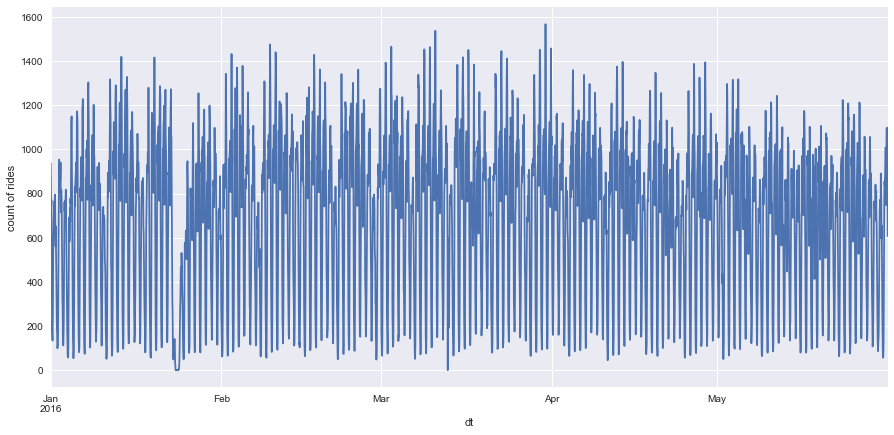

In [8]:
plt.figure(figsize=(15,7))
data.cnt.plot()
plt.ylabel('count of rides')
pylab.show()

## 2. Создайте регрессионные признаки для учёта сезонностей и трендов. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

Будем добавлять регрессионные признаки и делать регрессию.

In [9]:
k=10 # макс. значение к
T = data.shape[0]
data_regr = data.copy()
errs = []
for i in range(1, k + 1):
    data_regr["s_" + str(i)] = np.sin(np.array(range(1, T + 1)) * 2.0 * np.pi * float(i) / 168.0)
    data_regr["c_" + str(i)] = np.cos(np.array(range(1, T + 1)) * 2.0 * np.pi * float(i) / 168.0)
    XR = pd.DataFrame(data_regr, columns=data_regr.columns[1:])
    yR = data_regr['cnt']
    regr = LinearRegression(n_jobs=-1)
    regr.fit(XR, yR)
    yR_pred = regr.predict(XR)
    err = mean_squared_error(yR, yR_pred)
    errs.append(err)

Определим оптимальное К, такое при котором среднеквадратическая ошибка резко уменьшается. Из следующего графика видно, что К=6 (нумерация с нуля).

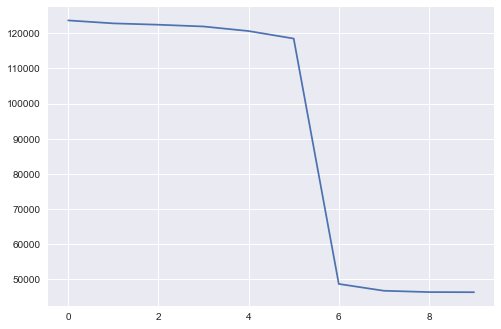

In [10]:
plt.plot(errs)
plt.show()

Обучим регрессионную модель при К=6, найдем остатки. Построим график получившегося ряда остатков.

In [11]:
k=6 # макс. значение к
T = data.shape[0]
data_regr = data.copy()
for i in range(1, k + 1):
    data_regr["s_" + str(i)] = np.sin(np.array(range(1, T + 1)) * 2.0 * np.pi * float(i) / 168.0)
    data_regr["c_" + str(i)] = np.cos(np.array(range(1, T + 1)) * 2.0 * np.pi * float(i) / 168.0)
XR = pd.DataFrame(data_regr, columns=data_regr.columns[1:])
yR = data_regr['cnt']
regr = LinearRegression(n_jobs=-1)
regr.fit(XR, yR)
yR_pred = regr.predict(XR)
data['rem'] = (yR - yR_pred)


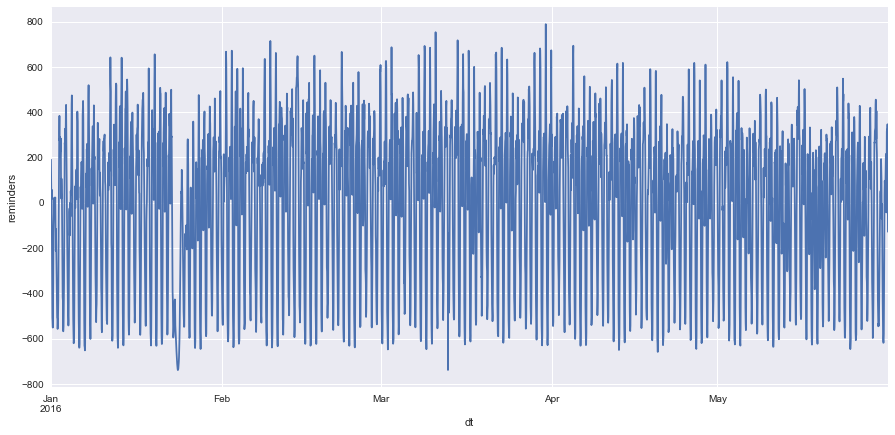

In [12]:
plt.figure(figsize=(15,7))
data.rem.plot()
plt.ylabel('reminders')
pylab.show()

## 3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

Проведем STL-декомпозицию ряда остатков.

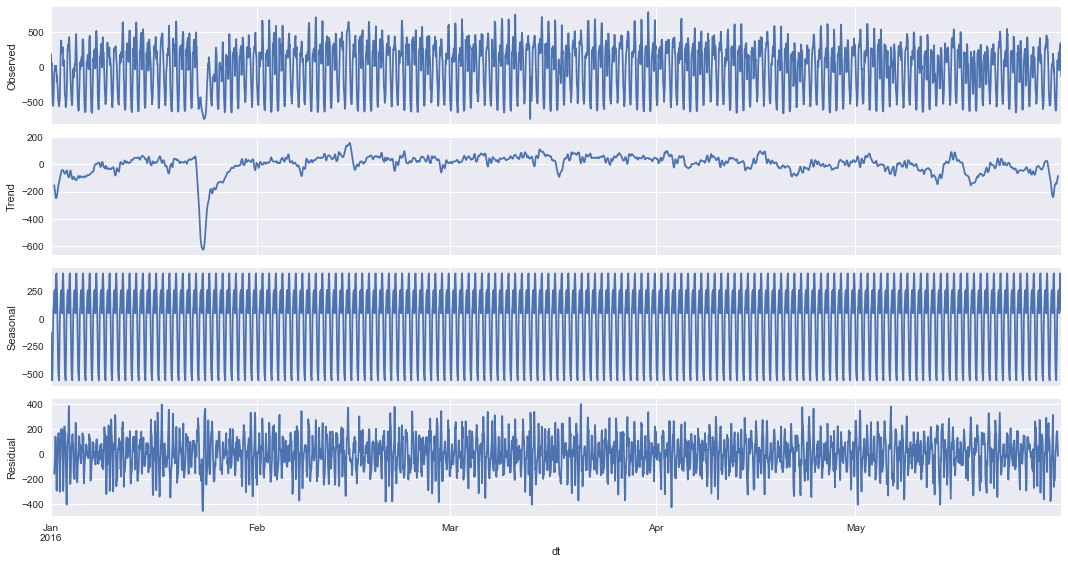

In [13]:
plt.figure(figsize(15,8))
sm.tsa.seasonal_decompose(data['rem']).plot()
plt.show()

In [27]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['rem'])[1])

Критерий Дики-Фуллера: p=0.000000


Тем не менее видно что ряд нестационарный. Проведем недельное дифференцирование, проведем STL-декомпозицию.

In [28]:
data['rem_diff168'] = data['rem'] - data['rem'].shift(168)

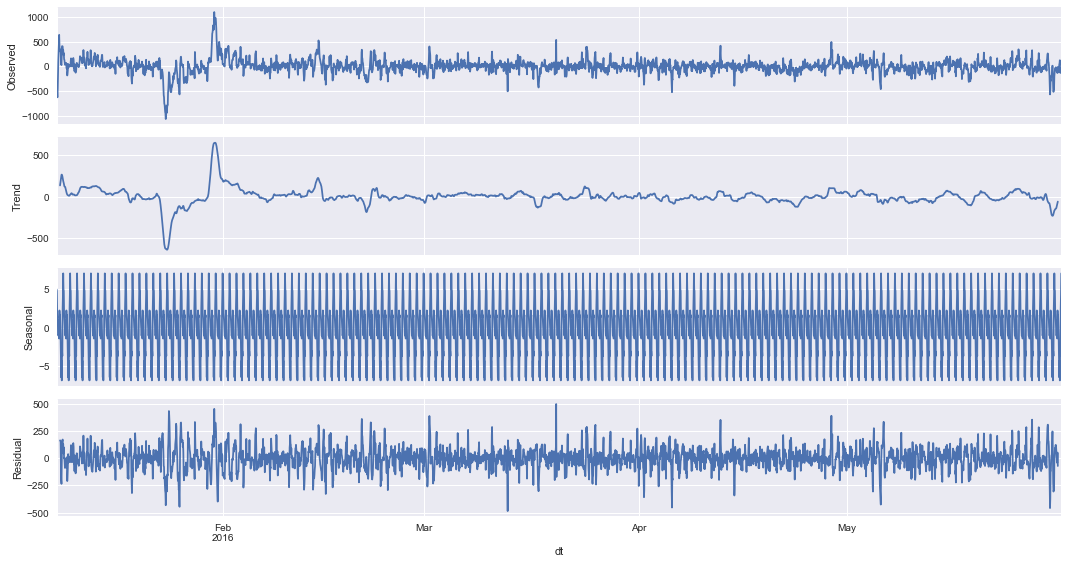

In [29]:
plt.figure(figsize(15,8))
sm.tsa.seasonal_decompose(data['rem_diff168'][168:]).plot()
plt.show()

Тем не менее видно что ряд нестационарный. Проведем суточное дифференцирование, проведем STL-декомпозицию.

In [32]:
data['rem_diff168_24'] = data['rem_diff168'] - data['rem_diff168'].shift(24)

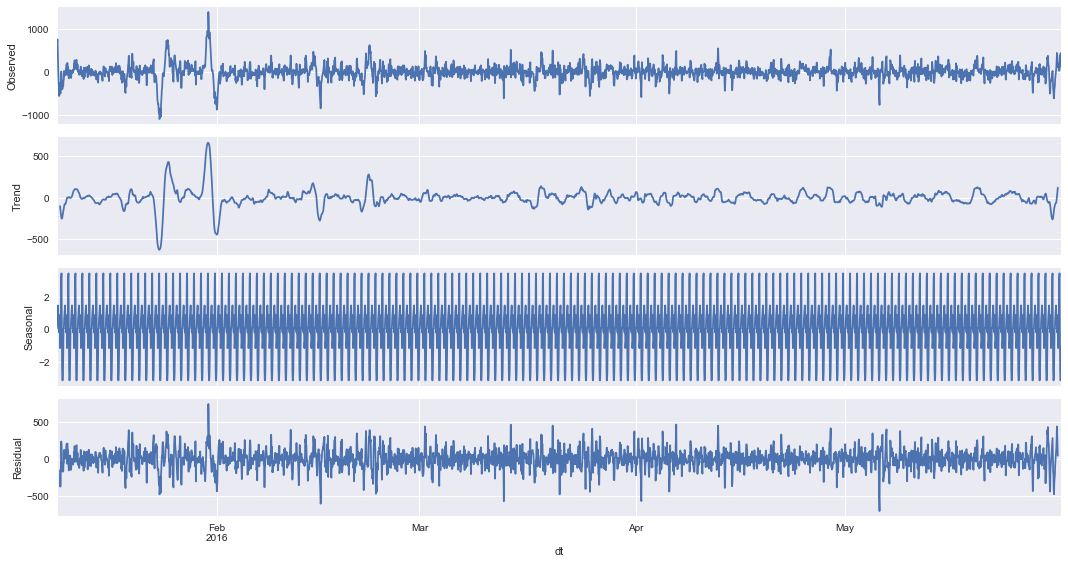

In [33]:
plt.figure(figsize(15,8))
sm.tsa.seasonal_decompose(data['rem_diff168_24'][192:]).plot()
plt.show()

Ряд по прежнему нестационарный. Проведем обычное дифференцирование, проведем STL-декомпозицию.

In [34]:
data['rem_diff168_24_1'] = data['rem_diff168_24'] - data['rem_diff168_24'].shift(1)

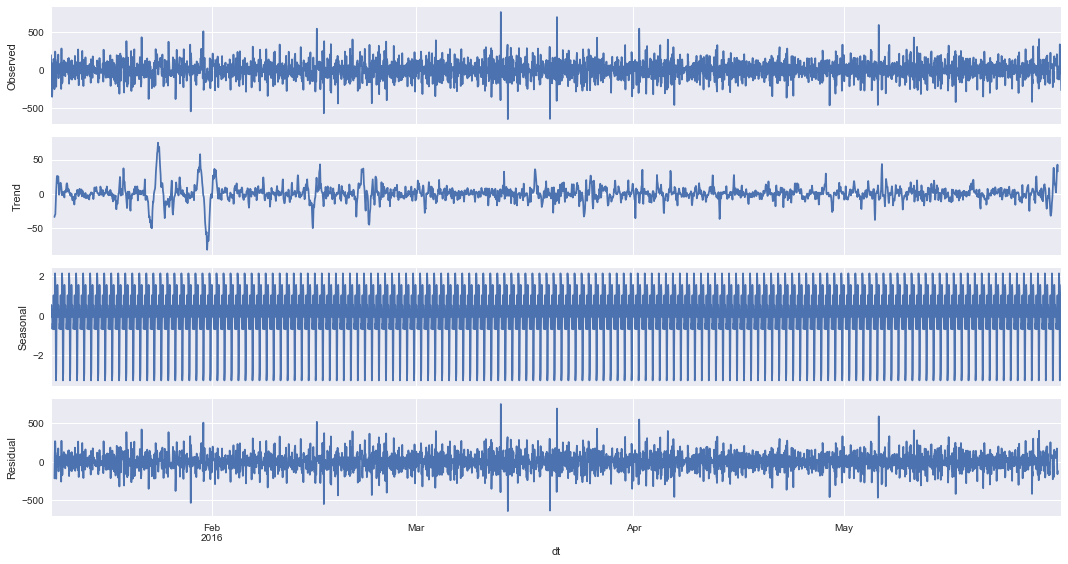

In [35]:
plt.figure(figsize(15,8))
sm.tsa.seasonal_decompose(data['rem_diff168_24_1'][193:]).plot()
plt.show()

Ряд стал более стационарным. Тренд колеблется в районе нуля.

## 4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

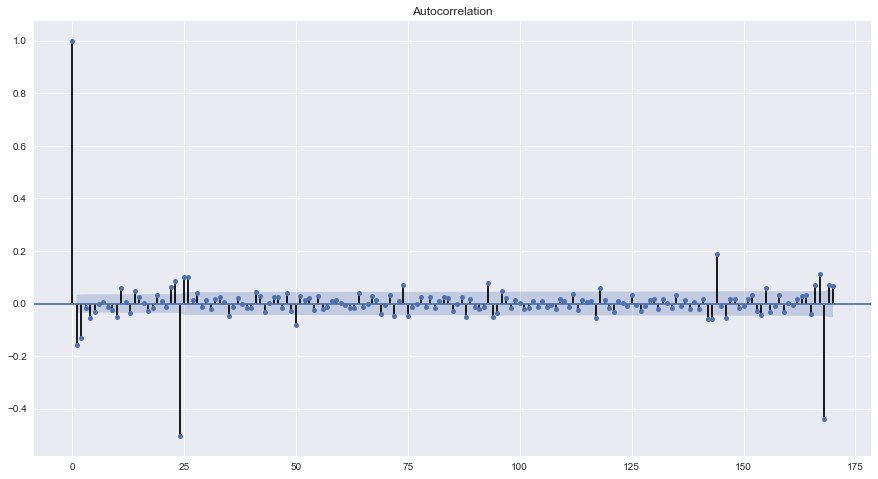

In [40]:
plt.figure(figsize=(15,8))
sm.graphics.tsa.plot_acf(data['rem_diff168_24_1'][193:].values.squeeze(), lags=(170))
plt.show()

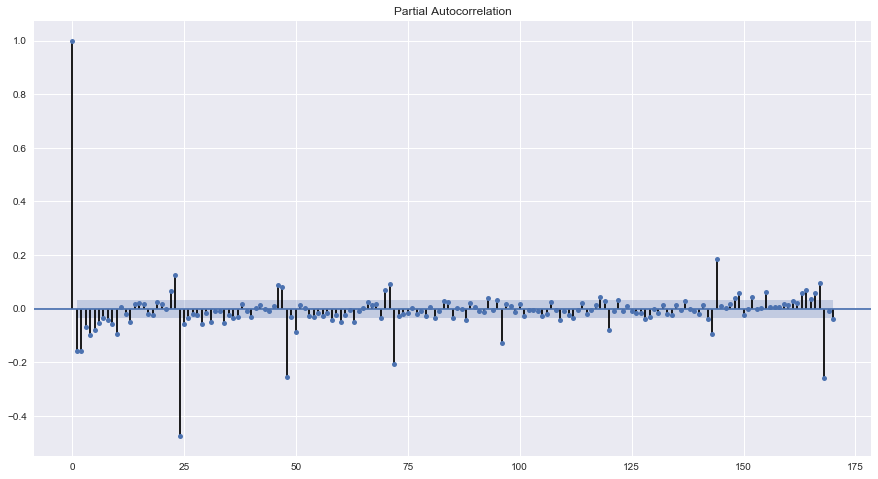

In [38]:
plt.figure(figsize=(15,8))
sm.graphics.tsa.plot_pacf(data['rem_diff168_24_1'][193:].values.squeeze(), lags=(170))
plt.show()

Выберем начальные приближения для параметров.

In [48]:
ps = range(0, 3)
d=1 
qs = range(0, 3)
Ps = range(0, 3)
D=1 
Qs = range(0, 2)

from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [49]:
%%time
model_results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['cnt'].values, exog=XR.values, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
               
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print 'wrong parameters:', param
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    model_results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (1, 2, 2, 0)
wrong parameters: (1, 2, 2, 1)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (2, 2, 2, 0)
wrong parameters: (2, 2, 2, 1)
Wall time: 1h 6min 49s


## 5. Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов K или поменять порядки дифференцирования.

In [50]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 3648
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 24)   Log Likelihood              -21101.836
Date:                            Tue, 18 Apr 2017   AIC                          42241.672
Time:                                    14:34:24   BIC                          42359.508
Sample:                                         0   HQIC                         42283.638
                                           - 3648                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -70.8247     10.840     -6.533      0.000     -92.071     -49.578
x2            57.8065     10.982   

Посмотрим, насколько хорошо модель описывает данные:

In [61]:
data['forecast'] = best_model.fittedvalues

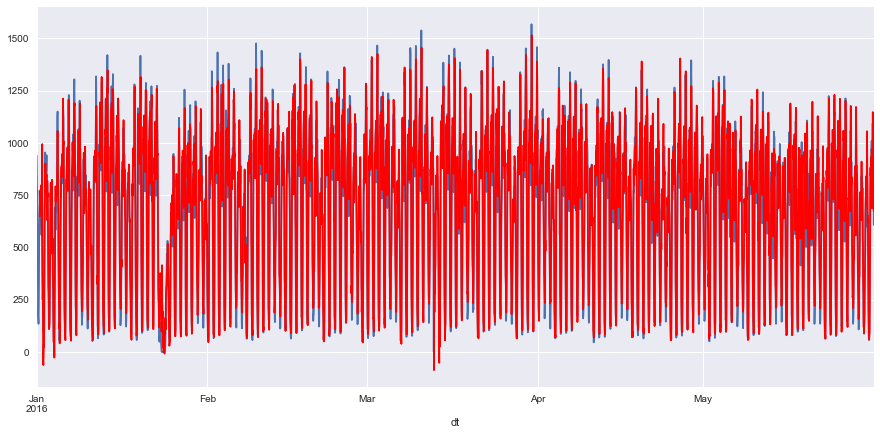

In [62]:
plt.figure(figsize=(15,7))
data.cnt.plot()
data.forecast[13:].plot(color='r')
pylab.show()

## 6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

Видно, что построенная модель совпадает с исходными данными. Рассмотрим более детально последние точки ряда, например, три последних дня. 

In [63]:
data_end = data.iloc[-72:]

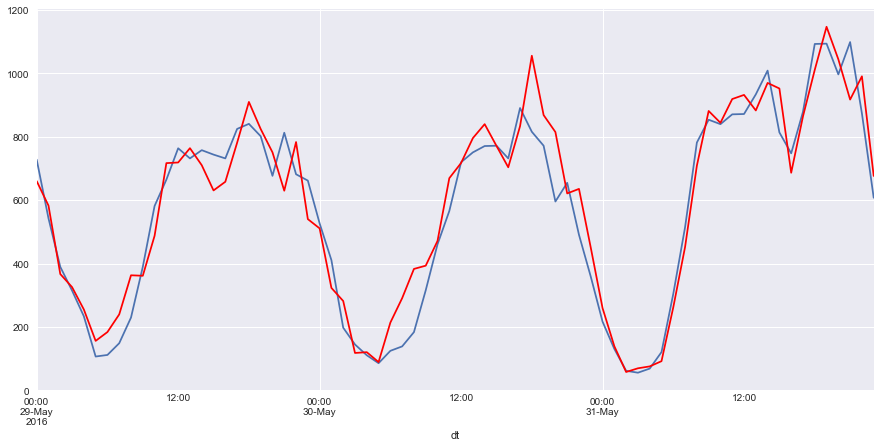

In [65]:
plt.figure(figsize=(15,7))
data_end.cnt.plot()
data_end.forecast.plot(color='r')
pylab.show()

Можно сделать вывод что прогноз адекватен, передает тренд и сезонность исходного ряда. Но  в точках максимума ряда наблюдаются отклонения.